# Test ML & Deep Learning - COVID-19 Classification

Ce notebook teste différents modèles de classification :
- **Machine Learning classique** : Random Forest, SVM, Logistic Regression
- **Deep Learning** : CNN personnalisé

Dataset : COVID-19 Radiography (4 classes)
- COVID
- Normal  
- Lung_Opacity
- Viral Pneumonia

## 1. Configuration et Imports

In [ ]:
# import sys
import logging
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
    # classification_report, confusion_matrix, accuracy_score,
    # f1_score, precision_score, recall_score
# )
# import warnings
# warnings.filterwarnings('ignore')

# Configuration paths
# project_root = Path.cwd().parent.parent

# from src.features.Pipelines.Transformateurs.image_loaders import ImageLoader
# from src.features.Pipelines.Transformateurs.image_preprocessing import (
#     ImageResizer, ImageNormalizer, ImageFlattener
# )
# from src.features.Pipelines.Transformateurs.image_augmentation import (
#     ImageAugmenter, ImageRandomCropper
# )
# from src.features.Pipelines.Transformateurs.image_features import (
#     ImageHistogram, ImagePCA, ImageStandardScaler
# )

# Configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')
# plt.rcParams['figure.figsize'] = (15, 10)
# sns.set_style('whitegrid')

# print(f"Project root: {project_root}")
# print("✅ Imports complets")

Project root: /home/cepa/DST/projet_DS/Data_Pipeline/Data_Pipeline
✅ Imports complets


## 2. Chargement des Données

In [ ]:
print("="*70)
print("CHARGEMENT DES DONNÉES")
print("="*70)

# # Chemins
# data_dir = project_root / 'data' / 'raw' / 'COVID-19_Radiography_Dataset' / 'COVID-19_Radiography_Dataset'
# categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Collecter images (100 par catégorie pour avoir un dataset raisonnable)
image_paths = []
labels = []
labels_int = []

for idx, cat in enumerate(categories):
    cat_path = data_dir / cat / 'images'
    if cat_path.exists():
        imgs = sorted(list(cat_path.glob('*.png')))[:100]  # 500 images par classe
        image_paths.extend(imgs)
        labels.extend([cat] * len(imgs))
        labels_int.extend([idx] * len(imgs))
        print(f"  {cat:20s}: {len(imgs):3d} images")

labels_int = np.array(labels_int)

print(f"\n  Total: {len(image_paths)} images")
print(f"  Classes: {len(categories)}")
print(f"  Distribution: {np.bincount(labels_int)}")

CHARGEMENT DES DONNÉES
  COVID               : 100 images
  Normal              : 100 images
  Lung_Opacity        : 100 images
  Viral Pneumonia     : 100 images

  Total: 400 images
  Classes: 4
  Distribution: [100 100 100 100]
  Normal              : 100 images
  Lung_Opacity        : 100 images
  Viral Pneumonia     : 100 images

  Total: 400 images
  Classes: 4
  Distribution: [100 100 100 100]


## 3. Préparation des Données - Pipeline de Base

In [4]:
print("\n" + "="*70)
print("PRÉPARATION DES IMAGES")
print("="*70)

# Pipeline de base : load + resize + normalize
prep_pipeline = Pipeline([
    ('load', ImageLoader(color_mode='L', verbose=False)),
    ('resize', ImageResizer(img_size=(128, 128), verbose=False)),
    ('norm', ImageNormalizer(method='minmax', verbose=False))
])

images = prep_pipeline.fit_transform(image_paths)

print(f"\n📊 Images préparées:")
print(f"  Shape: {images.shape}")
print(f"  Range: [{images.min():.3f}, {images.max():.3f}]")
print(f"  Mean: {images.mean():.3f}")
print(f"  Std: {images.std():.3f}")


PRÉPARATION DES IMAGES

📊 Images préparées:
  Shape: (400, 128, 128)
  Range: [0.000, 1.000]
  Mean: 0.515
  Std: 0.252

📊 Images préparées:
  Shape: (400, 128, 128)
  Range: [0.000, 1.000]
  Mean: 0.515
  Std: 0.252


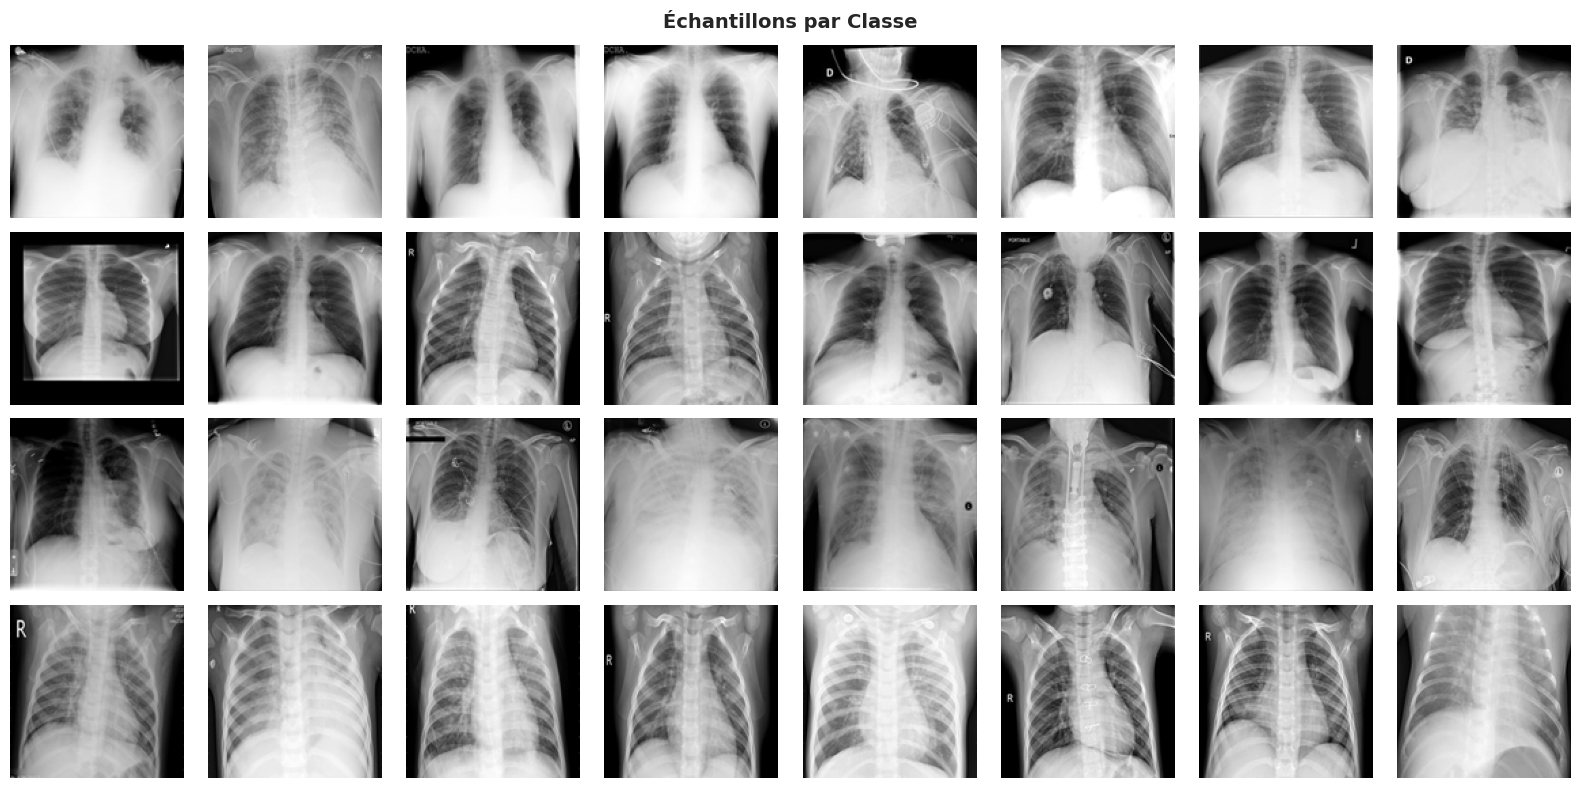

In [5]:
# Visualisation d'échantillons
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(4):  # 4 classes
    for j in range(8):  # 8 exemples par classe
        idx = i * 100 + j  # 100 images par classe
        axes[i, j].imshow(images[idx], cmap='gray')
        if j == 0:
            axes[i, j].set_ylabel(categories[i], rotation=0, ha='right', va='center', fontsize=10)
        axes[i, j].axis('off')

plt.suptitle('Échantillons par Classe', size=14, weight='bold')
plt.tight_layout()
plt.show()

## 4. Split Train/Test

In [6]:
print("\n" + "="*70)
print("SPLIT TRAIN/TEST")
print("="*70)

# Split stratifié (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_int,
    test_size=0.2,
    random_state=42,
    stratify=labels_int
)

print(f"\nTrain set: {X_train.shape[0]} images")
print(f"  Distribution: {np.bincount(y_train)}")
print(f"\nTest set: {X_test.shape[0]} images")
print(f"  Distribution: {np.bincount(y_test)}")


SPLIT TRAIN/TEST

Train set: 320 images
  Distribution: [80 80 80 80]

Test set: 80 images
  Distribution: [20 20 20 20]


## 5. Machine Learning - Approche 1: Features PCA

In [7]:
print("\n" + "="*70)
print("ML APPROCHE 1: FEATURES PCA")
print("="*70)

# Pipeline de features avec PCA
max_pca_comp = min(X_train.shape[0], np.prod(X_train.shape[1:]))
n_pca = min(100, max_pca_comp)

feature_pipeline_pca = Pipeline([
    ('flatten', ImageFlattener(verbose=False)),
    ('scale', ImageStandardScaler(verbose=False)),
    ('pca', ImagePCA(n_components=n_pca, random_state=42, verbose=False))
])

X_train_pca = feature_pipeline_pca.fit_transform(X_train)
X_test_pca = feature_pipeline_pca.transform(X_test)

pca_variance = feature_pipeline_pca.named_steps['pca'].explained_variance_ratio_
print(f"\n  Features PCA: {X_train_pca.shape[1]}")
print(f"  Variance expliquée: {pca_variance:.2%}")


ML APPROCHE 1: FEATURES PCA

  Features PCA: 100
  Variance expliquée: 95.35%

  Features PCA: 100
  Variance expliquée: 95.35%


In [8]:
# Test de 3 modèles ML avec features PCA
print("\nEntraînement des modèles ML (PCA features)...\n")

ml_models_pca = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
}

results_pca = {}

for name, model in ml_models_pca.items():
    print(f"  Training {name}...")
    model.fit(X_train_pca, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train_pca)
    y_pred_test = model.predict(X_test_pca)
    
    # Métriques
    results_pca[name] = {
        'model': model,
        'train_acc': accuracy_score(y_train, y_pred_train),
        'test_acc': accuracy_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test, average='weighted'),
        'precision': precision_score(y_test, y_pred_test, average='weighted'),
        'recall': recall_score(y_test, y_pred_test, average='weighted'),
        'y_pred': y_pred_test
    }
    
    print(f"    Train Acc: {results_pca[name]['train_acc']:.3f}")
    print(f"    Test Acc:  {results_pca[name]['test_acc']:.3f}")
    print(f"    F1 Score:  {results_pca[name]['f1']:.3f}\n")


Entraînement des modèles ML (PCA features)...

  Training Random Forest...
    Train Acc: 1.000
    Test Acc:  0.637
    F1 Score:  0.631

  Training SVM (RBF)...
    Train Acc: 0.919
    Test Acc:  0.675
    F1 Score:  0.668

  Training Logistic Regression...
    Train Acc: 1.000
    Test Acc:  0.637
    F1 Score:  0.631

  Training SVM (RBF)...
    Train Acc: 0.919
    Test Acc:  0.675
    F1 Score:  0.668

  Training Logistic Regression...
    Train Acc: 1.000
    Test Acc:  0.600
    F1 Score:  0.606

    Train Acc: 1.000
    Test Acc:  0.600
    F1 Score:  0.606



## 6. Machine Learning - Approche 2: Features Histogram

In [9]:
print("\n" + "="*70)
print("ML APPROCHE 2: FEATURES HISTOGRAM")
print("="*70)

# Pipeline avec histogrammes
feature_pipeline_hist = Pipeline([
    ('histogram', ImageHistogram(bins=64, density=True, verbose=False)),
    ('scale', ImageStandardScaler(verbose=False))
])

X_train_hist = feature_pipeline_hist.fit_transform(X_train)
X_test_hist = feature_pipeline_hist.transform(X_test)

print(f"\n  Features Histogram: {X_train_hist.shape[1]}")


ML APPROCHE 2: FEATURES HISTOGRAM

  Features Histogram: 64

  Features Histogram: 64


In [10]:
# Test avec Random Forest (meilleur modèle généralement)
print("\nEntraînement Random Forest (Histogram features)...\n")

rf_hist = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_hist.fit(X_train_hist, y_train)

y_pred_hist = rf_hist.predict(X_test_hist)

acc_hist = accuracy_score(y_test, y_pred_hist)
f1_hist = f1_score(y_test, y_pred_hist, average='weighted')

print(f"  Test Accuracy: {acc_hist:.3f}")
print(f"  F1 Score:      {f1_hist:.3f}")


Entraînement Random Forest (Histogram features)...

  Test Accuracy: 0.725
  F1 Score:      0.724
  Test Accuracy: 0.725
  F1 Score:      0.724


## 7. Machine Learning - Approche 3: Features Combinées

In [11]:
print("\n" + "="*70)
print("ML APPROCHE 3: FEATURES COMBINÉES (PCA + HISTOGRAM)")
print("="*70)

# Combiner PCA et Histogram
X_train_combined = np.hstack([X_train_pca, X_train_hist])
X_test_combined = np.hstack([X_test_pca, X_test_hist])

print(f"\n  Features combinées: {X_train_combined.shape[1]}")
print(f"    PCA: {X_train_pca.shape[1]}")
print(f"    Histogram: {X_train_hist.shape[1]}")


ML APPROCHE 3: FEATURES COMBINÉES (PCA + HISTOGRAM)

  Features combinées: 164
    PCA: 100
    Histogram: 64


In [12]:
# Test Random Forest avec features combinées
print("\nEntraînement Random Forest (Combined features)...\n")

rf_combined = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_combined.fit(X_train_combined, y_train)

y_pred_combined = rf_combined.predict(X_test_combined)

acc_combined = accuracy_score(y_test, y_pred_combined)
f1_combined = f1_score(y_test, y_pred_combined, average='weighted')

print(f"  Test Accuracy: {acc_combined:.3f}")
print(f"  F1 Score:      {f1_combined:.3f}")


Entraînement Random Forest (Combined features)...

  Test Accuracy: 0.688
  F1 Score:      0.682
  Test Accuracy: 0.688
  F1 Score:      0.682


## 8. Deep Learning - CNN Simple

In [13]:
print("\n" + "="*70)
print("DEEP LEARNING: CNN")
print("="*70)

# Vérifier si TensorFlow/Keras est disponible
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.utils import to_categorical
    
    print(f"\n✅ TensorFlow version: {tf.__version__}")
    
    # Désactiver les avertissements TF
    tf.get_logger().setLevel('ERROR')
    
    KERAS_AVAILABLE = True
    
except ImportError:
    print("\n⚠️  TensorFlow non installé. Installation requise pour le CNN.")
    print("    pip install tensorflow")
    KERAS_AVAILABLE = False


DEEP LEARNING: CNN


2025-11-05 11:17:27.033759: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 11:17:27.036865: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-05 11:17:27.270524: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-05 11:17:27.599098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762337847.830355   34060 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762337847.87


✅ TensorFlow version: 2.18.0


In [14]:
if KERAS_AVAILABLE:
    # Préparer les données pour CNN
    X_train_cnn = X_train[..., np.newaxis]  # Ajouter canal (N, 128, 128, 1)
    X_test_cnn = X_test[..., np.newaxis]
    
    y_train_cat = to_categorical(y_train, num_classes=4)
    y_test_cat = to_categorical(y_test, num_classes=4)
    
    print(f"\nDonnées CNN:")
    print(f"  X_train: {X_train_cnn.shape}")
    print(f"  X_test:  {X_test_cnn.shape}")
    print(f"  y_train: {y_train_cat.shape}")
    print(f"  y_test:  {y_test_cat.shape}")


Données CNN:
  X_train: (320, 128, 128, 1)
  X_test:  (80, 128, 128, 1)
  y_train: (320, 4)
  y_test:  (80, 4)


In [16]:
if KERAS_AVAILABLE:
    # Architecture CNN simple mais efficace
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\n📐 Architecture CNN:")
    model.summary()

2025-11-05 11:19:00.182692: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



📐 Architecture CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,404 (24.87 MB)

 Trainable params: 6,517,444 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
if KERAS_AVAILABLE:
    print("\nEntraînement du CNN...\n")
    
    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    # Entraînement
    history = model.fit(
        X_train_cnn, y_train_cat,
        validation_data=(X_test_cnn, y_test_cat),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Évaluation
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
    print(f"\n📊 Résultats CNN:")
    print(f"  Test Accuracy: {test_acc:.3f}")
    print(f"  Test Loss:     {test_loss:.3f}")


Entraînement du CNN...

Epoch 1/50
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5969 - loss: 1.4127 - val_accuracy: 0.2500 - val_loss: 2.2026 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5969 - loss: 1.4127 - val_accuracy: 0.2500 - val_loss: 2.2026 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7281 - loss: 0.7212 - val_accuracy: 0.2500 - val_loss: 4.8446 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7281 - loss: 0.7212 - val_accuracy: 0.2500 - val_loss: 4.8446 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7531 - loss: 0.6068 - val_accuracy: 0.2500 - val_loss: 7.6446 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7531 - loss: 0.6068 - val_accuracy: 0.2500 - val_loss: 7.6446 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.

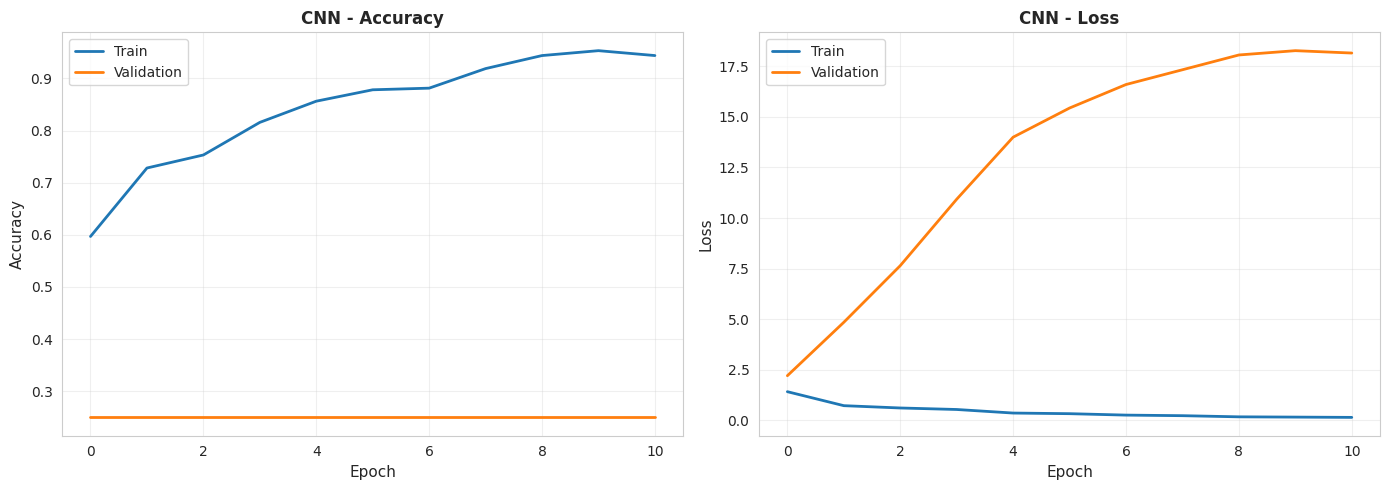

In [18]:
if KERAS_AVAILABLE:
    # Courbes d'apprentissage
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Accuracy', fontsize=11)
    axes[0].set_title('CNN - Accuracy', fontsize=12, weight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].set_title('CNN - Loss', fontsize=12, weight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Prédictions pour confusion matrix
    y_pred_cnn_proba = model.predict(X_test_cnn, verbose=0)
    y_pred_cnn = np.argmax(y_pred_cnn_proba, axis=1)

## 9. Comparaison des Modèles

In [20]:
print("\n" + "="*70)
print("COMPARAISON DES MODÈLES")
print("="*70)

# Tableau comparatif
comparison = []

# ML avec PCA
for name, res in results_pca.items():
    comparison.append({
        'Modèle': f"{name} (PCA)",
        'Accuracy': res['test_acc'],
        'F1': res['f1'],
        'Precision': res['precision'],
        'Recall': res['recall']
    })

# ML avec Histogram
comparison.append({
    'Modèle': 'Random Forest (Hist)',
    'Accuracy': acc_hist,
    'F1': f1_hist,
    'Precision': precision_score(y_test, y_pred_hist, average='weighted'),
    'Recall': recall_score(y_test, y_pred_hist, average='weighted')
})

# ML avec features combinées
comparison.append({
    'Modèle': 'Random Forest (Combined)',
    'Accuracy': acc_combined,
    'F1': f1_combined,
    'Precision': precision_score(y_test, y_pred_combined, average='weighted'),
    'Recall': recall_score(y_test, y_pred_combined, average='weighted')
})

# CNN si disponible
if KERAS_AVAILABLE:
    comparison.append({
        'Modèle': 'CNN',
        'Accuracy': test_acc,
        'F1': f1_score(y_test, y_pred_cnn, average='weighted'),
        'Precision': precision_score(y_test, y_pred_cnn, average='weighted'),
        'Recall': recall_score(y_test, y_pred_cnn, average='weighted')
    })

# Affichage
print("\n{:<35s} {:>10s} {:>10s} {:>10s} {:>10s}".format(
    'Modèle', 'Accuracy', 'F1', 'Precision', 'Recall'
))
print("-" * 80)

for comp in sorted(comparison, key=lambda x: x['Accuracy'], reverse=True):
    print("{:<35s} {:>10.3f} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        comp['Modèle'],
        comp['Accuracy'],
        comp['F1'],
        comp['Precision'],
        comp['Recall']
    ))

# Meilleur modèle
best = max(comparison, key=lambda x: x['Accuracy'])
print("\n" + "="*70)
print(f"🏆 MEILLEUR MODÈLE: {best['Modèle']} (Accuracy: {best['Accuracy']:.3f})")
print("="*70)


COMPARAISON DES MODÈLES

Modèle                                Accuracy         F1  Precision     Recall
--------------------------------------------------------------------------------
Random Forest (Hist)                     0.725      0.724      0.726      0.725
Random Forest (Combined)                 0.688      0.682      0.681      0.688
SVM (RBF) (PCA)                          0.675      0.668      0.684      0.675
Random Forest (PCA)                      0.637      0.631      0.631      0.637
Logistic Regression (PCA)                0.600      0.606      0.617      0.600
CNN                                      0.250      0.100      0.062      0.250

🏆 MEILLEUR MODÈLE: Random Forest (Hist) (Accuracy: 0.725)


## 10. Matrices de Confusion

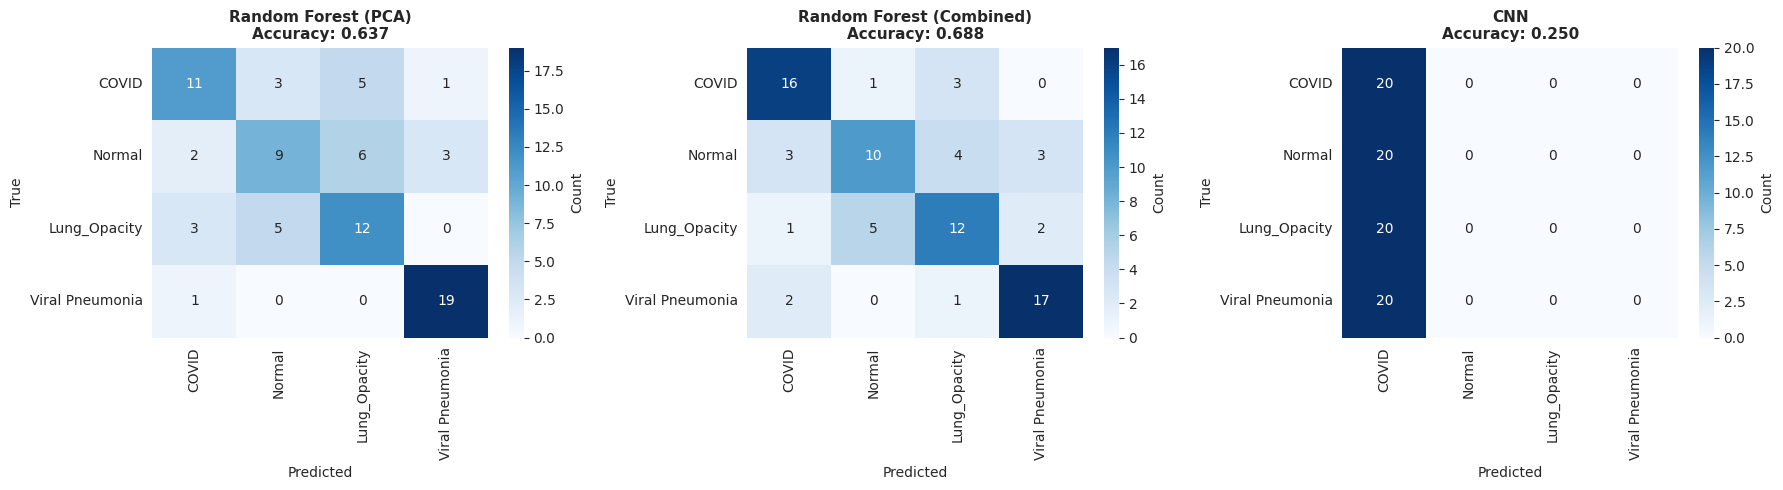

In [21]:
# Sélection des meilleurs modèles à visualiser
models_to_viz = [
    ('Random Forest (PCA)', results_pca['Random Forest']['y_pred']),
    ('Random Forest (Combined)', y_pred_combined),
]

if KERAS_AVAILABLE:
    models_to_viz.append(('CNN', y_pred_cnn))

# Créer les confusion matrices
n_models = len(models_to_viz)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for ax, (name, y_pred) in zip(axes, models_to_viz):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=categories, yticklabels=categories,
        ax=ax, cbar_kws={'label': 'Count'}
    )
    
    acc = accuracy_score(y_test, y_pred)
    ax.set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=11, weight='bold')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

## 11. Rapports de Classification Détaillés

In [22]:
print("\n" + "="*70)
print("RAPPORTS DE CLASSIFICATION DÉTAILLÉS")
print("="*70)

for name, y_pred in models_to_viz:
    print(f"\n{'='*70}")
    print(f"{name}")
    print(f"{'='*70}\n")
    print(classification_report(y_test, y_pred, target_names=categories))


RAPPORTS DE CLASSIFICATION DÉTAILLÉS

Random Forest (PCA)

                 precision    recall  f1-score   support

          COVID       0.65      0.55      0.59        20
         Normal       0.53      0.45      0.49        20
   Lung_Opacity       0.52      0.60      0.56        20
Viral Pneumonia       0.83      0.95      0.88        20

       accuracy                           0.64        80
      macro avg       0.63      0.64      0.63        80
   weighted avg       0.63      0.64      0.63        80


Random Forest (Combined)

                 precision    recall  f1-score   support

          COVID       0.73      0.80      0.76        20
         Normal       0.62      0.50      0.56        20
   Lung_Opacity       0.60      0.60      0.60        20
Viral Pneumonia       0.77      0.85      0.81        20

       accuracy                           0.69        80
      macro avg       0.68      0.69      0.68        80
   weighted avg       0.68      0.69      0.68       

## 12. Visualisation des Erreurs

In [23]:
# Visualiser quelques erreurs du meilleur modèle
best_model_name = best['Modèle']
best_y_pred = None

for name, y_pred in models_to_viz:
    if name == best_model_name:
        best_y_pred = y_pred
        break

if best_y_pred is not None:
    # Trouver les erreurs
    errors = np.where(y_test != best_y_pred)[0]
    
    if len(errors) > 0:
        print(f"\n{best_model_name} - Erreurs: {len(errors)}/{len(y_test)}")
        
        # Visualiser les 8 premières erreurs
        n_errors = min(8, len(errors))
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.ravel()
        
        for i in range(n_errors):
            idx = errors[i]
            axes[i].imshow(X_test[idx], cmap='gray')
            axes[i].set_title(
                f'True: {categories[y_test[idx]]}\n'
                f'Pred: {categories[best_y_pred[idx]]}',
                size=9, color='red'
            )
            axes[i].axis('off')
        
        for i in range(n_errors, 8):
            axes[i].axis('off')
        
        plt.suptitle(f'{best_model_name} - Exemples d\'Erreurs', size=13, weight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n🎉 {best_model_name}: Aucune erreur sur le test set!")

## 13. Résumé Final

In [24]:
print("\n" + "="*70)
print("RÉSUMÉ FINAL")
print("="*70)

print("\n📊 Dataset:")
print(f"  Total images: {len(image_paths)}")
print(f"  Classes: {len(categories)}")
print(f"  Train/Test: {len(X_train)}/{len(X_test)}")

print("\n🔧 Transformers utilisés:")
print("  • ImageLoader")
print("  • ImageResizer")
print("  • ImageNormalizer")
print("  • ImageFlattener")
print("  • ImageStandardScaler")
print("  • ImagePCA")
print("  • ImageHistogram")

print("\n🤖 Modèles testés:")
print(f"  • Machine Learning: {len(results_pca) + 2} modèles")
if KERAS_AVAILABLE:
    print(f"  • Deep Learning: 1 CNN")

print(f"\n🏆 Meilleur modèle:")
print(f"  {best['Modèle']}")
print(f"  Accuracy:  {best['Accuracy']:.3f}")
print(f"  F1 Score:  {best['F1']:.3f}")
print(f"  Precision: {best['Precision']:.3f}")
print(f"  Recall:    {best['Recall']:.3f}")

print("\n✨ Prochaines étapes:")
print("  1. Augmenter le dataset (plus de 100 images/classe)")
print("  2. Data augmentation pour le CNN")
print("  3. Transfer learning (VGG16, ResNet, EfficientNet)")
print("  4. Hyperparameter tuning (GridSearch, Optuna)")
print("  5. Interprétabilité (GradCAM, SHAP, LIME)")

print("\n" + "="*70)
print("🎉 TESTS COMPLÉTÉS AVEC SUCCÈS!")
print("="*70)


RÉSUMÉ FINAL

📊 Dataset:
  Total images: 400
  Classes: 4
  Train/Test: 320/80

🔧 Transformers utilisés:
  • ImageLoader
  • ImageResizer
  • ImageNormalizer
  • ImageFlattener
  • ImageStandardScaler
  • ImagePCA
  • ImageHistogram

🤖 Modèles testés:
  • Machine Learning: 5 modèles
  • Deep Learning: 1 CNN

🏆 Meilleur modèle:
  Random Forest (Hist)
  Accuracy:  0.725
  F1 Score:  0.724
  Precision: 0.726
  Recall:    0.725

✨ Prochaines étapes:
  1. Augmenter le dataset (plus de 100 images/classe)
  2. Data augmentation pour le CNN
  3. Transfer learning (VGG16, ResNet, EfficientNet)
  4. Hyperparameter tuning (GridSearch, Optuna)
  5. Interprétabilité (GradCAM, SHAP, LIME)

🎉 TESTS COMPLÉTÉS AVEC SUCCÈS!
